# Decision Tree

In [1]:
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import copy
import warnings
warnings.filterwarnings('ignore')

## Phase0: Data Analysis


### loading data

In [2]:
data=pd.read_csv("dataset.csv")
data

,type,title,cast,country,release_year,listed_in,description
0,Movie,Dick Johnson Is Dead,NaN,United States,2020,Documentaries,"As her father nears the end of his life, filmm..."
1,TV Show,Blood & Water,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,TV Show,Ganglands,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,TV Show,Jailbirds New Orleans,NaN,NaN,2021,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,TV Show,Kota Factory,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...
11054,TV Show,X-Men: Evolution,"Noel Fisher, Vincent Gale, Christopher Judge, ...",United States,2000,"Action-Adventure, Animation, Kids",X-Men: Evolution features the team as teenager...
11055,TV Show,Smart Guy,"Tahj Mowry, John Jones, Jason Weaver, Essence ...",United States,1996,"Comedy, Coming of Age, Kids",A genius tries to fit in as a high school soph...
11056,TV Show,Disney Kirby Buckets,"Jacob Bertrand, Mekai Curtis, Cade Sutton, Oli...",United States,2014,"Action-Adventure, Comedy, Coming of Age",Welcome to Kirby's world! It's rude and sketchy.
11057,TV Show,Disney Mech-X4,"Nathaniel Potvin, Raymond Cham, Kamran Lucas, ...",Canada,2016,"Action-Adventure, Comedy, Science Fiction",Ryan discovers his ability to control a giant ...


### Data Information

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11059 entries, 0 to 11058
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   type          11059 non-null  object
 1   title         11059 non-null  object
 2   cast          9694 non-null   object
 3   country       8364 non-null   object
 4   release_year  11059 non-null  int64 
 5   listed_in     11059 non-null  object
 6   description   11059 non-null  object
dtypes: int64(1), object(6)
memory usage: 604.9+ KB


In [4]:
data.describe()

,release_year
count,11059.000000
mean,2014.209603
std,8.959517
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2019.000000
max,2021.000000


### Missing Data

In [5]:
data.isnull().sum(axis = 0)

type               0
title              0
cast            1365
country         2695
release_year       0
listed_in          0
description        0
dtype: int64

## Phase1: Preprocess

### Dealing With Missing Values
There are several ways to deal with missing values, here two of them is discussed:
 - deleting data: we may choose to remove rows with missing data if the number of rows with missing data is insignifiant, or if it is not possible to easily estimate them. We may also remove the column if it is insignificant or has too may missing values
 
 
 - filling data: we may choose to fill the missing values with an estimation. this can be a predetermined default value or attributes like mean/median/mode. the downside of this method is the loss of variance and correlation with other data. We may also choose to use more complex methods like ML algorithms to estimate missing data, this can solve the problems mentioned earlier, however it highly depends on the method. 
 in this case we chose to replace missing value for "cast" column with an empty set and replace the missing values of "country" column with the mode of other data. The reason is that for there may be some correlation between the "cast" and "type" columns so it is better to not use values like mode for this. this is not an issue for "country" column, so we replaced the empty rows with mode.

In [6]:
def replace_missing_data(data):
    data['country'] = data['country'].fillna(data['country'].mode()[0]);
    data['cast'] = data['cast'].fillna("");

### Normalization and Standardization
In order to keep our result from being affected by difference in feature scales, we can use either normalization or standardization:

- Normalization: this method rescales the data to be in range [0,1]. the formula is:
$$data_{normalized}=\frac{data-data_{min}}{data_{max}-data_{min}}$$

- Standardization: this method rescales the data so that the mean is 0 and std is 1. 
$$data_{standardized}=\frac{data-mean}{std}$$

in our dataset, the only numerical value is "release_year". Since the decision tree is not actually dependent on scales (as it considers each feature separatly and divide the tree by choosing a threshold). both normalization and standardization would be fine here. we chose standardization.

In [7]:
def standardize(data):
    data['release_year']=(data['release_year']-data['release_year'].mean())/data['release_year'].std()

### Categorical Data

there are several ways to handle categorical data:

- Adding categories as features: in this method, we add a column for each category and set the corresponding row to 1 if that row belongs to category. This method may not be good if we have to many categories.
-  replacing categories with numbers: in this method, we assign a number to each category. this method is better suited for ordinal categories.

In this part, we replace the "type" column with corresponding numbers:


In [8]:
def replace_categorical_data(data):
    labels = data['type'].astype('category').cat.categories.tolist()
    replace_map = {'type' : {labels[0]:0,labels[1]:1}}
    data.replace(replace_map, inplace=True)

### Listed Data

To handle listed data, we use the "Adding categories as features" method which was described in previous part. however there is no need to use all of the names that appear on the list because using the rare values would cause overfitting. so we choose the $\alpha$ most common values in each column for new features, where $\alpha$ is a parameter given as input.

In [9]:
import operator
def replace_listed_data(data,col,alpha):
    features={}
    for i in range(len(data[col])): 
        x=data[col][i].split(",");
        for word in x:
            if word in features: 
                features[word]+=1;
            else:
                features[word]=1;
        data[col][i]=x
    sorted_features=sorted(features.items(), key=operator.itemgetter(1))
    for i in range(alpha):
        feature=sorted_features[-i-1][0]
        data[feature]=0;
        for j in range(len(data[col])):
            if feature in data[col][j] :
                data[feature][j]=1

### Count Vectorizer

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
def count_vectorize():
    cv=CountVectorizer(max_df=0.95, min_df=2,max_features=10000,stop_words='english')
    data["title"]=cv.fit_transform(data["title"]);
    data["description"]=cv.fit_transform(data["description"]);


### Overall

In [11]:
def preprocess(data,cv=False):
    replace_missing_data(data);
    standardize(data);
    replace_categorical_data(data);
    replace_listed_data(data,"listed_in",20);
    replace_listed_data(data,"country",10);
    replace_listed_data(data,"cast",10);
    if(cv):
        count_vectorize(data)
    data = data.drop(columns=["listed_in","country","cast","title","description"],inplace=True);

preprocess(data);
display(data);

,type,release_year,International Movies,Dramas,Comedies,Action & Adventure,Documentaries,Dramas,International TV Shows,Independent Movies,...,,Anupam Kher,Takahiro Sakurai,Rupa Bhimani,Julie Tejwani,Om Puri,Yuki Kaji,Vincent Tong,Shah Rukh Khan,Rajesh Kava
0,0,0.646285,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,0.757898,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.757898,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0.757898,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1,0.757898,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11054,1,-1.585979,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11055,1,-2.032431,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11056,1,-0.023394,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11057,1,0.199832,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Information Gain

<BarContainer object of 41 artists>

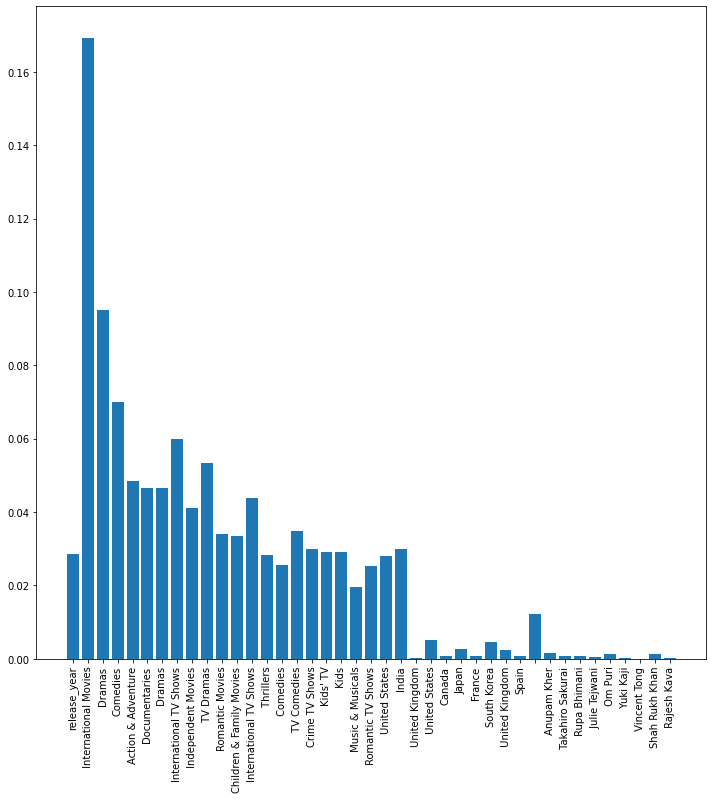

In [12]:
from sklearn.feature_selection import mutual_info_classif
tdata=copy.deepcopy(data)
tdata=tdata.drop(columns=["type"])
gain=mutual_info_classif(tdata, data["type"], discrete_features=True)
res = dict(zip(tdata.columns,gain))
plt.figure(figsize=(12,12))
plt.xticks(rotation='vertical')
plt.bar(*zip(*res.items()))

## Phase2: Decision Tree
In this part, we use the sklearn library to implement a decision tree.

### Train and Test Data
first we split our data into train and test.

In [13]:
from sklearn.model_selection import train_test_split
def split_data(p=0.2):
    train, test = train_test_split(data, test_size=p)
    return train,test;

### Making the Tree
in this part we make a decision tree using the sklearn library function. then we try to change the hyper parameters to make the model better. the hyper parameters include:
- max_depth: this parameter indicates the maximum depth of the tree. If max_depth is reached, the node becomes a leaf and wont be splited.
- min_samples_split: this parameter indicates the minimum number of samples needed to split a node, In other words, a node wont split and becomes a leaf if it has fewer samples than min_samples_split.

In [14]:
from sklearn import tree

def build_tree(train,md=10):
    tdata=copy.deepcopy(train)
    tdata=tdata.drop(columns=["type"])
    clf = tree.DecisionTreeClassifier(max_depth=md);
    clf = clf.fit(tdata, train['type']);
    return clf

### Evaluation

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#### 1- Test and Train Split Parameter
in this part, we split the data with 3 different test sizes and compaare the results

##### test=20% data:
we choose this split because we wanted to use most of the data for train. but the test data cannot be very small or the accuracy would depend on the way the data is splited and would not be a good estimate for our models performance.

In [16]:
train,test=split_data(0.2)
dt=build_tree(train)
# plt.figure(figsize=(12,12))
# tree.plot_tree(dt,fontsize=10)
# plt.show()
tdata=copy.deepcopy(test)
tdata=tdata.drop(columns=["type"])
res=dt.predict(tdata)
accuracy_score(test["type"],res)

0.9439421338155516

##### test=2% data:
as mentioned earlier, when using a very small test data, the accuracy would be dependent on the split method and wont be accurate. in this case, the result is close to what we achieved above.

In [17]:
train,test=split_data(0.02)
dt=build_tree(train)
tdata=copy.deepcopy(test)
tdata=tdata.drop(columns=["type"])
res=dt.predict(tdata)
accuracy_score(test["type"],res)

0.963963963963964

##### test=60% data:
in this case, since the train data is small, the model has not seen enough samples so it may fail to predict correctly.

In [18]:
train,test=split_data(0.6)
dt=build_tree(train)
tdata=copy.deepcopy(test)
tdata=tdata.drop(columns=["type"])
res=dt.predict(tdata)
accuracy_score(test["type"],res)

0.9439421338155516

#### 2- max_depth Effect
in this part, we make a model with different max_depth values and compare the results.

Text(0, 0.5, 'accuracy')

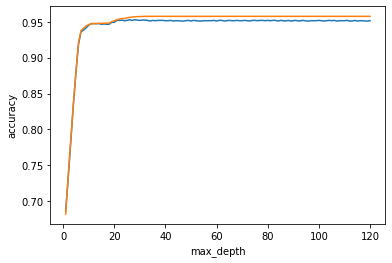

In [19]:
train,test=split_data(0.2)
tdata=copy.deepcopy(test)
tdata=tdata.drop(columns=["type"])
tdata2=copy.deepcopy(train)
tdata2=tdata2.drop(columns=["type"])

x=[]
trn=[]
tst=[]
for md in range(120):
    dt=build_tree(train,md+1)
    res=dt.predict(tdata)
    res2=dt.predict(tdata2)
    x.append(md+1)
    trn.append(accuracy_score(train["type"],res2))
    tst.append(accuracy_score(test["type"],res))
plt.plot(x,tst)
plt.plot(x,trn)
plt.xlabel("max_depth")
plt.ylabel("accuracy")

It can be seen that with the increase of max_depth, the accuracy on train data increases, but the accuracy on test data stops to grow.


## Phase3: Random Forest
In this part, we want to use random forest model to predict the outputs and see the effect of two hyperparameters.
- n_estimators: this parameter indicates the number of trees used in random forest.
- max_depth: the max_depth of all trees.

In [20]:
def build_forest(train,md=10,ne=5):
    tdata=copy.deepcopy(train)
    tdata=tdata.drop(columns=["type"])
    clf = RandomForestClassifier(n_estimators=ne,max_depth=md);
    clf = clf.fit(tdata, train['type']);
    return clf

In [21]:
from sklearn.ensemble import RandomForestClassifier
train,test=split_data(0.2)
tdata=copy.deepcopy(test)
tdata=tdata.drop(columns=["type"])
tdata2=copy.deepcopy(train)
tdata2=tdata2.drop(columns=["type"])

##### max_depth:
similar to decision tree, the accuracy will increase as the depth increases, however the plot is uneven.

Text(0, 0.5, 'accuracy')

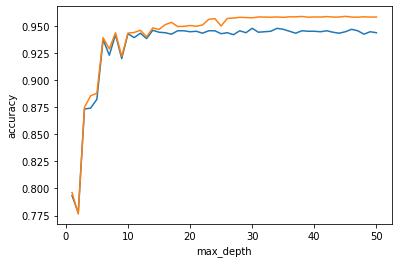

In [22]:
x=[]
trn=[]
tst=[]
for md in range(50):
    dt=build_forest(train,md+1)
    res=dt.predict(tdata)
    res2=dt.predict(tdata2)
    x.append(md+1)
    trn.append(accuracy_score(train["type"],res2))
    tst.append(accuracy_score(test["type"],res))
plt.plot(x,tst)
plt.plot(x,trn)
plt.xlabel("max_depth")
plt.ylabel("accuracy")

##### n_estimator:
we can see that the n_estimator does not have a linear relation with accuracy and its changes are uneven 

Text(0, 0.5, 'accuracy')

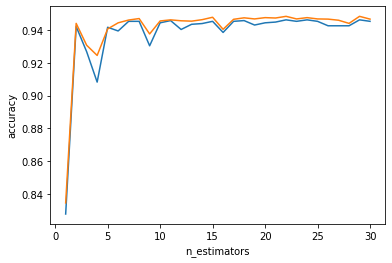

In [23]:
x=[]
trn=[]
tst=[]
for en in range(30):
    dt=build_forest(train,10,en+1)
    res=dt.predict(tdata)
    res2=dt.predict(tdata2)
    x.append(en+1)
    trn.append(accuracy_score(train["type"],res2))
    tst.append(accuracy_score(test["type"],res))
plt.plot(x,tst)
plt.plot(x,trn)
plt.xlabel("n_estimators")
plt.ylabel("accuracy")

## Conclusion

In this sample, it was hard to see the difference in variance and bias between random forest and decision tree. however, we can say that random forest is less likely to be high biased because of its ensemble nature. and is less likely to be high variant because it uses several decision trees and is not effected by noise and outliers as much as a single decision tree.